In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image, ImageOps
import os
import math
import json
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torch.optim as optim

import cv2

import random
import numpy as np
    
import matplotlib.pyplot as plt

In [30]:

degree = 180 / math.pi
radian = math.pi / 180
# https://math.stackexchange.com/questions/13150/extracting-rotation-scale-values-from-2d-transformation-matrix/13165#13165
# def TransformDecomposition(transform):
#     a = transform[0,0]
#     b = transform[0,1]
#     c = transform[1,0]
#     d = transform[1,1]

#     tx = transform[0,2]
#     ty = transform[1,2]

#     scaleX = math.sqrt((a * a) + (c * c))
#     scaleY = math.sqrt((b * b) + (d * d))

#     sign = math.atan(-c / a)
#     rad  = math.acos(a / scaleX)
#     deg  = rad * degree

#     if (deg > 90 and sign > 0):
#         rotation = (360 - deg) * radian
#     elif (deg < 90 and sign < 0):
#         rotation = (360 - deg) * radian
#     else:
#         rotation = rad
#     rotationInDegree = rotation * degree

#     return tx, ty, scaleX, scaleY, rotationInDegree

# https://math.stackexchange.com/questions/13150/extracting-rotation-scale-values-from-2d-transformation-matrix/13165#13165
def TransformDecomposition(transform):
    a = transform[0,0]
    b = transform[0,1]
    c = transform[1,0]
    d = transform[1,1]

    tx = transform[0,2]
    ty = transform[1,2]
    delta = a * d - b * c

    if (a != 0 or b != 0):
        r = math.sqrt(a * a + b * b)
        rotation = math.acos(a / r) if b > 0 else -math.acos(a / r)
        scaleX, scaleY = r, delta / r
        # skew = (math.atan((a * c + b * d) / (r * r)), 0)
    elif (c != 0 or d != 0):
        s = math.sqrt(c * c + d * d)
        rotation = math.PI / 2 - (math.acos(-c / s) if d > 0 else -math.acos(c / s))
        scaleX, scaleY = delta / s, s
        # skew = (0, math.atan((a * c + b * d) / (s * s)))
    else:
        a = b = c = d = 0

    rotationInDegree = rotation * degree
    return tx, ty, scaleX, scaleY, rotationInDegree

    

[[ 6.1275959e-01  3.3914287e-02  8.0371411e+02]
 [-3.3914287e-02  6.1275959e-01  4.7639679e+02]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 6.12759600e-01  3.39142845e-02  8.17048273e+02]
 [-3.39142845e-02  6.12759600e-01  4.81395275e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 5.885128e-01 -4.773544e-02  4.507047e+02]
 [ 4.773544e-02  5.885128e-01  3.730157e+02]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]
[[ 5.88512793e-01 -4.77354421e-02  4.23533765e+02]
 [ 4.77354421e-02  5.88512793e-01  3.95923089e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 5.4194033e-01  6.2515676e-02  7.7923254e+02]
 [-6.2515676e-02  5.4194033e-01  5.7412030e+02]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 5.41940371e-01  6.25156805e-02  7.95559453e+02]
 [-6.25156805e-02  5.41940371e-01  5.81869056e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 6.9476527e-01 -8.9137163e-03  2.6707971e+02]
 [ 8.9137163e-03  6.9476527e-01  3.3756787e+02]
 [ 0.0000000e+00

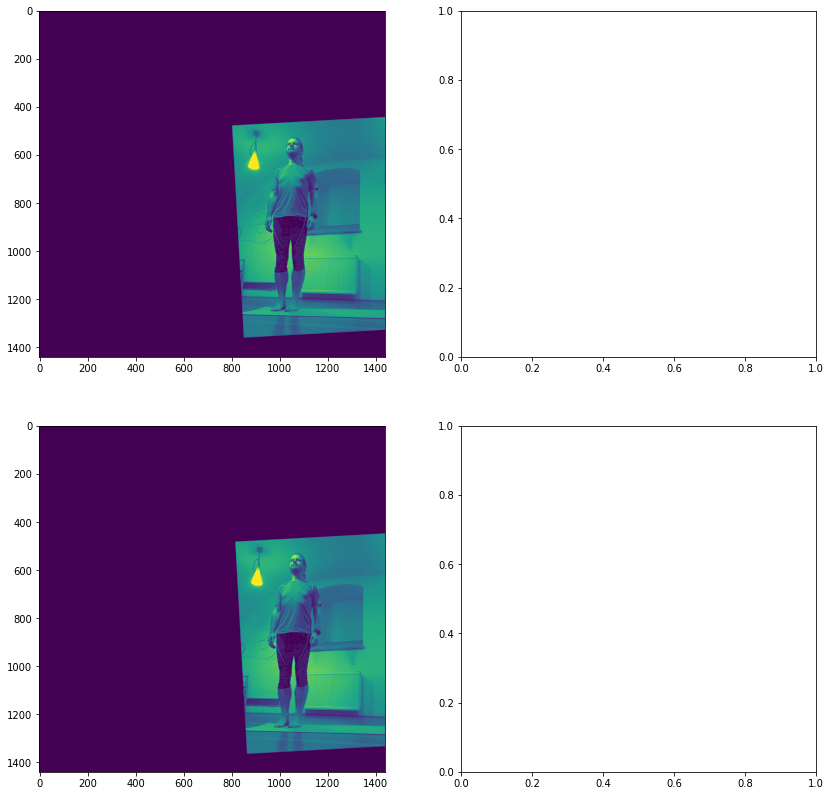

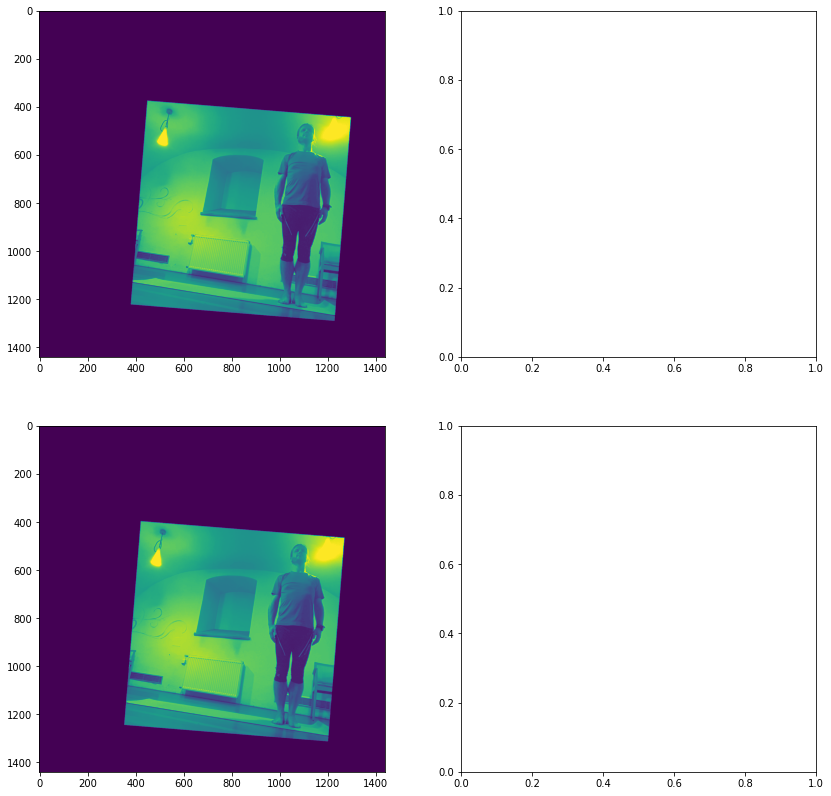

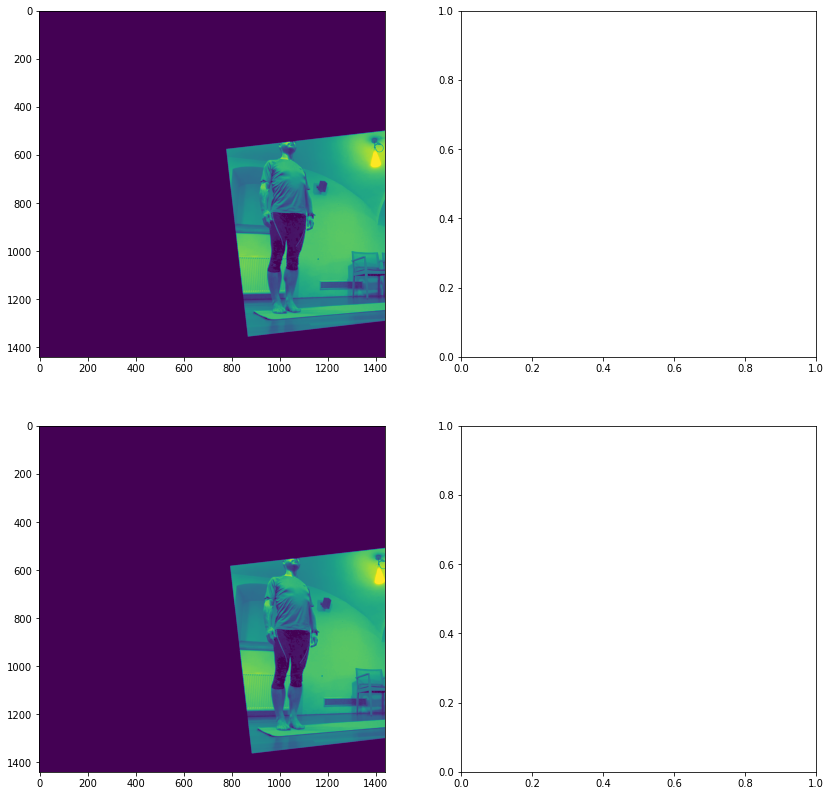

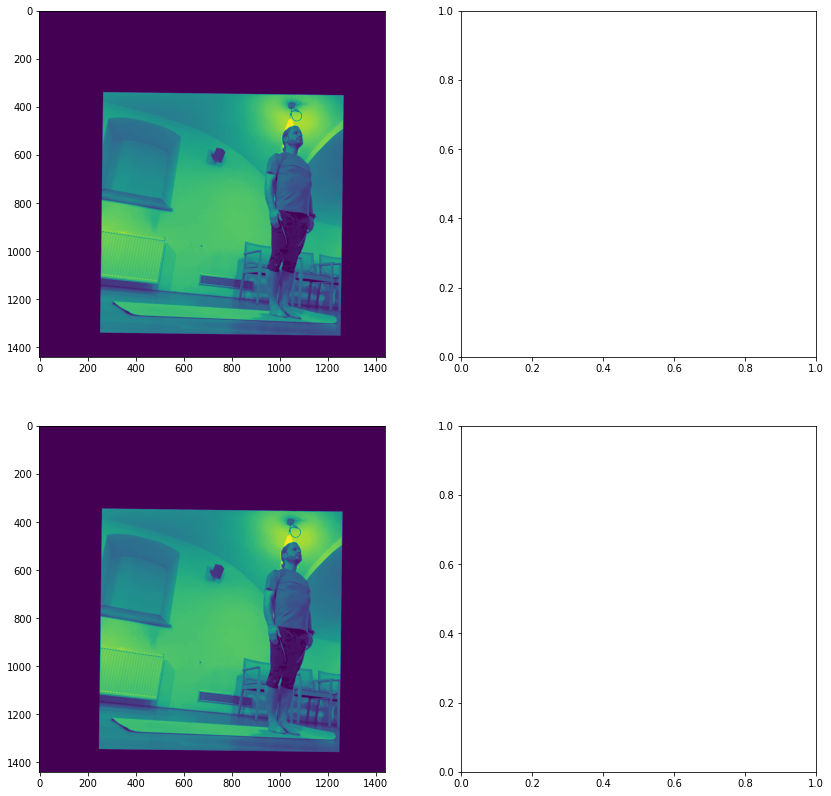

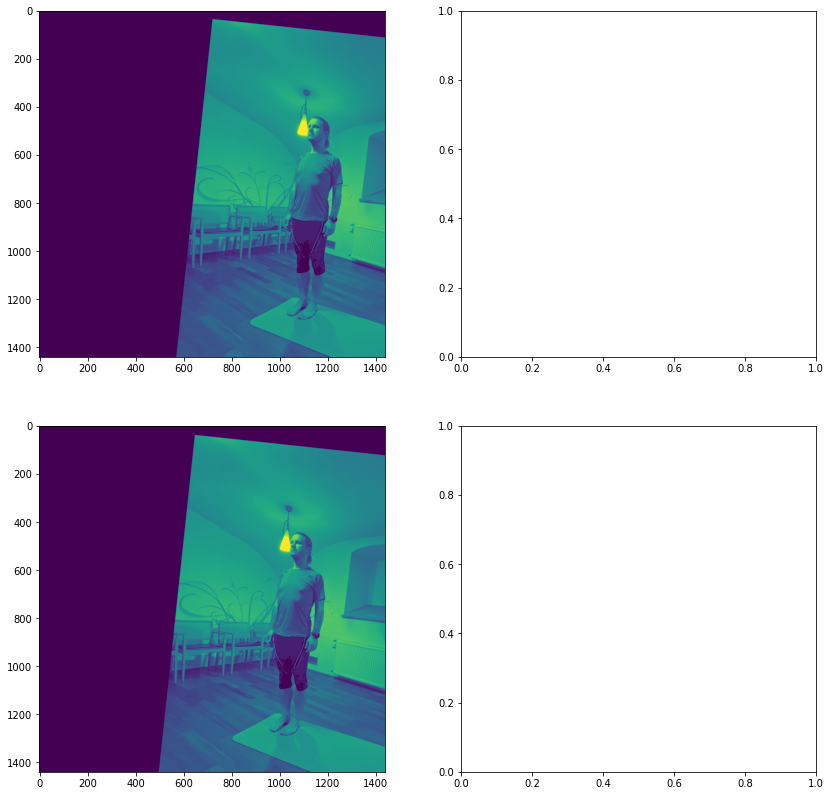

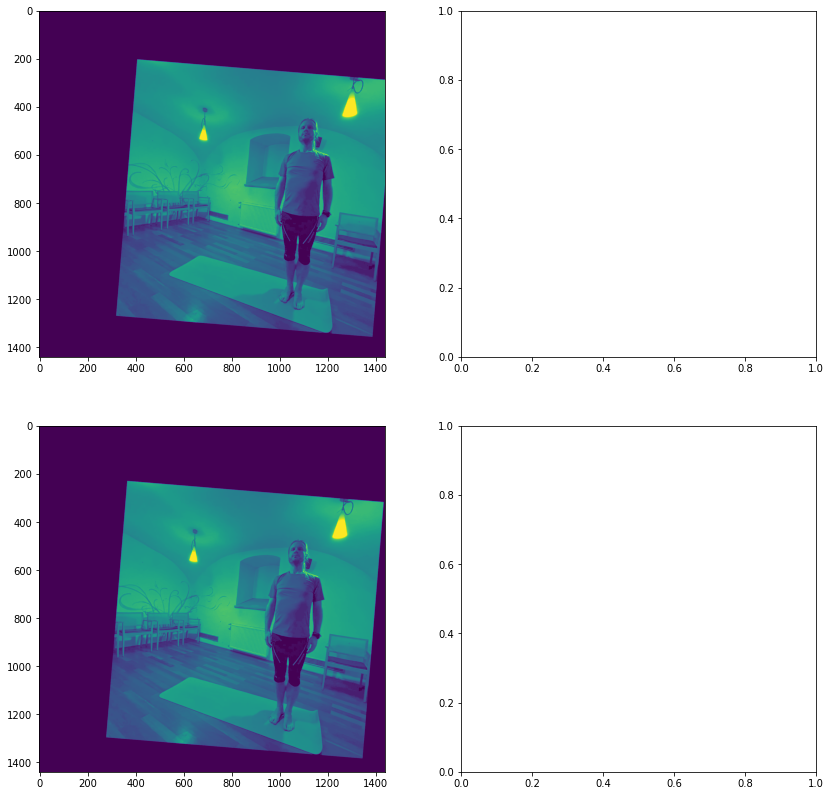

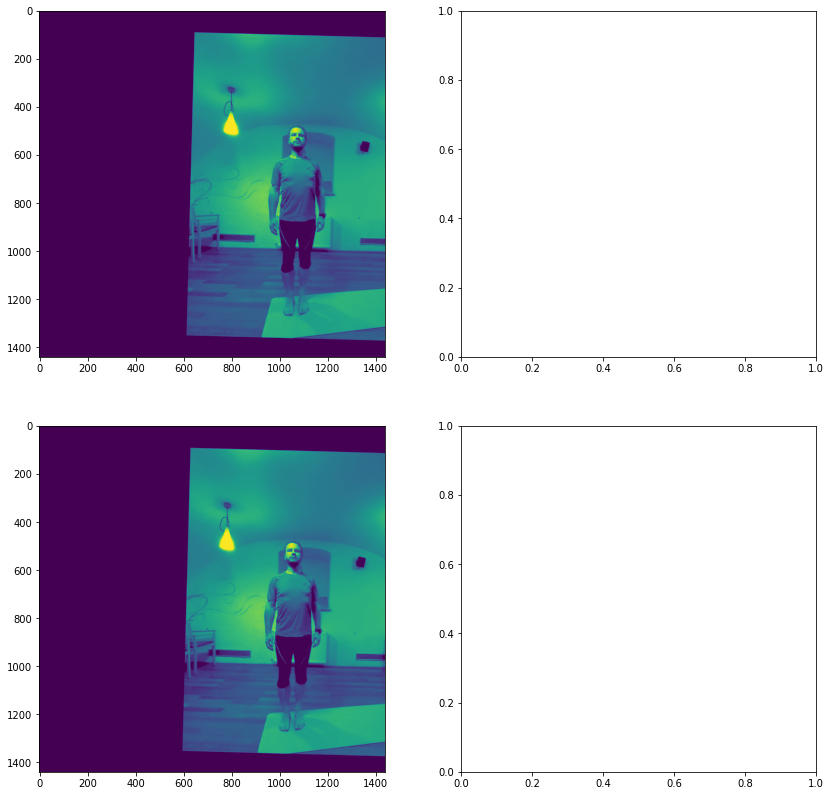

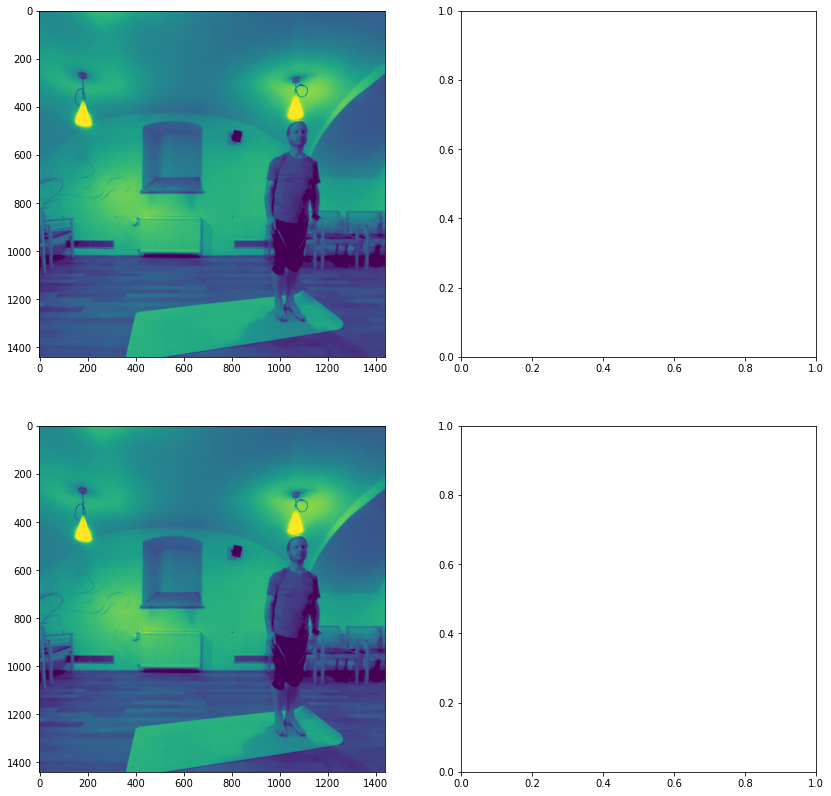

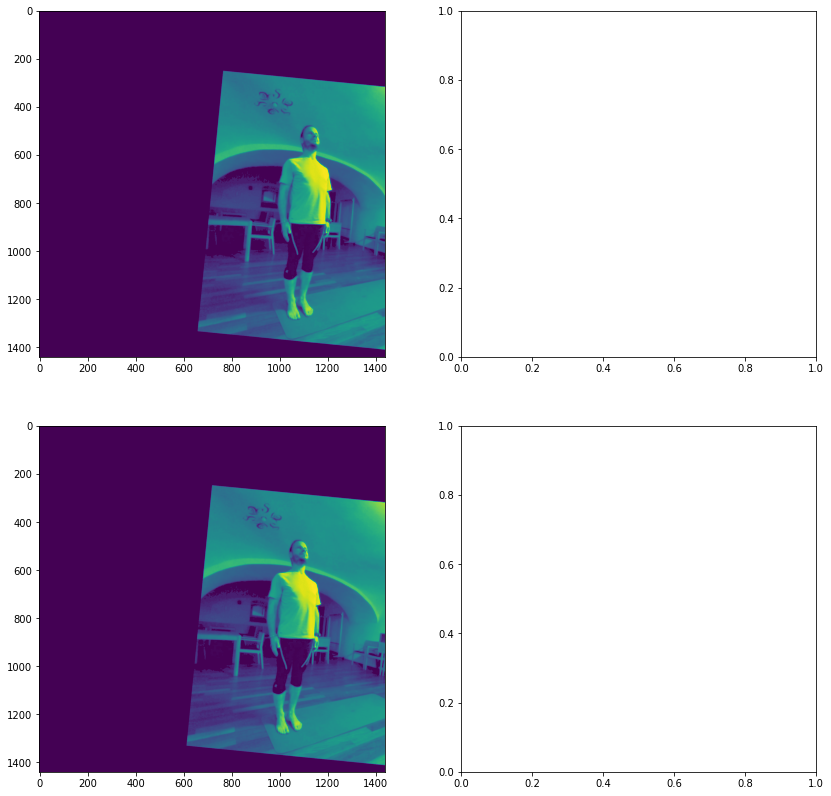

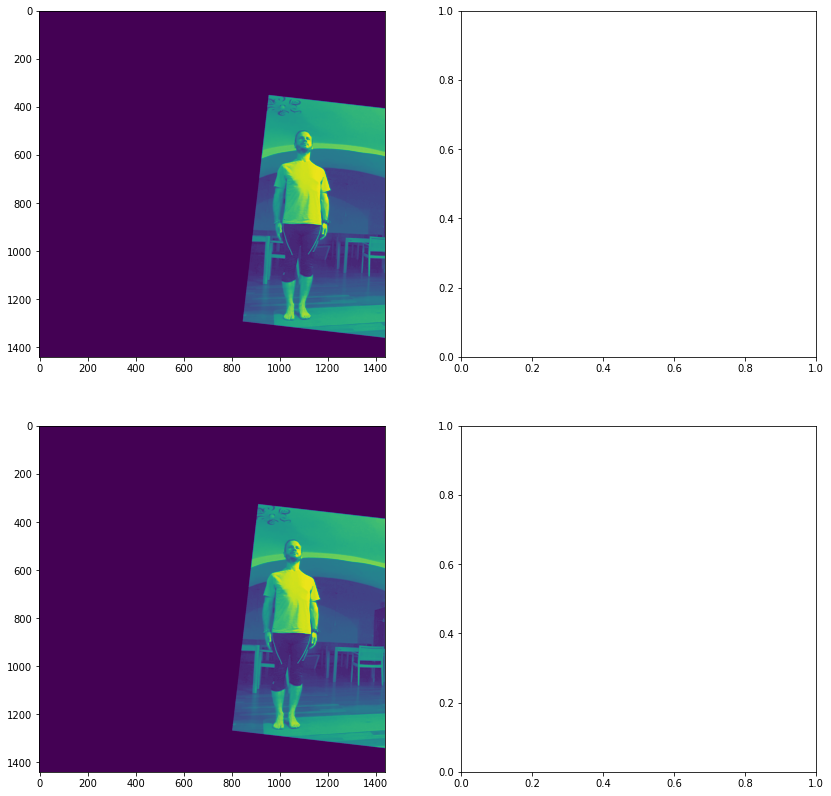

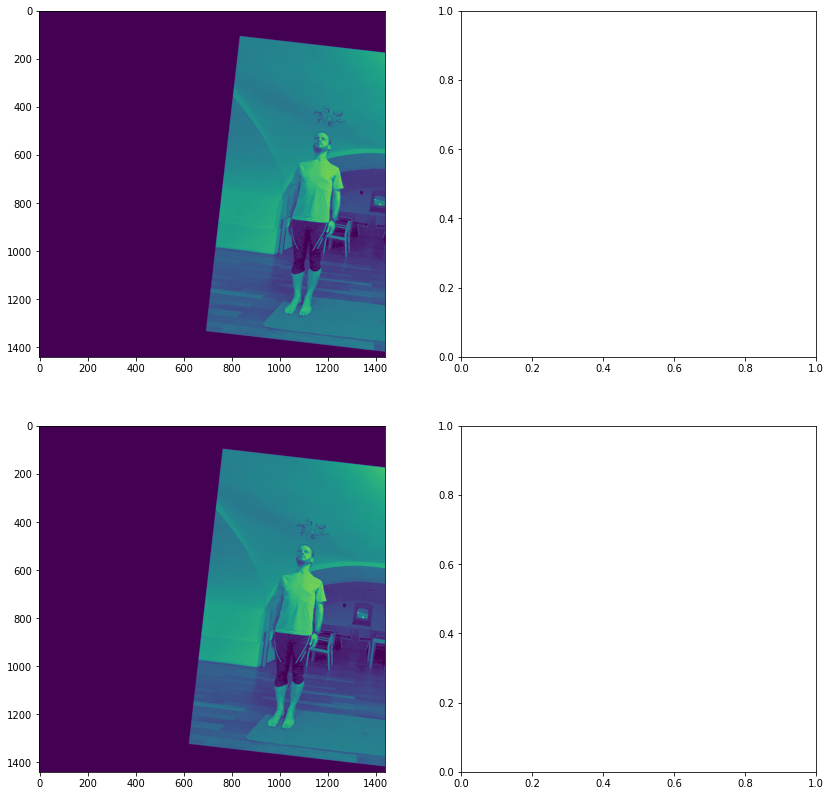

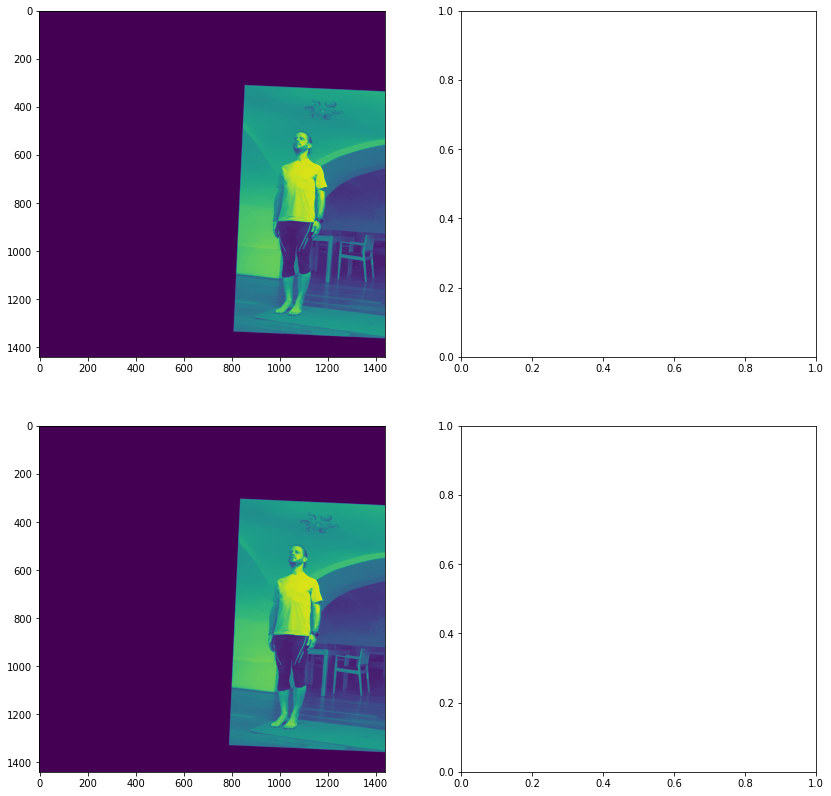

In [31]:
files = os.listdir('.\\..\\data03\MachineData')

for ML_Record in files:
    DatasetItem = json.load(open(os.path.join('.\\..\\data03\MachineData', ML_Record)))
    src = cv2.imread(DatasetItem["src"], cv2.IMREAD_GRAYSCALE)
    dst = cv2.imread(DatasetItem["dst"], cv2.IMREAD_GRAYSCALE)
    originalTransfrom = np.matrix(DatasetItem["transformation"])

    translationX = random.uniform(80, 150) * random.choice([1, -1])
    translationY = random.uniform(80, 120) * random.choice([1, -1])
    scale = random.uniform(0.8, 1.2)
    rotation = random.uniform(5, 15) * random.choice([1, -1])

    AugmentingMat = np.mat([[scale, 0., translationX], [0., scale, translationY], [0., 0., 1.]] , dtype=np.float32)
    rotationMat = cv2.getRotationMatrix2D( (src.shape[1]//2, src.shape[0]//2), rotation, 1)
    AugmentingMat = np.matmul(np.vstack([rotationMat, [0,0,1]]), AugmentingMat, dtype=np.float32)

    invertedAugmentingMat = np.mat(cv2.invertAffineTransform(AugmentingMat[0:-1, : ]))
    invertedAugmentingMat = np.vstack([invertedAugmentingMat, [0,0,1]])

    GeneratedTransform = originalTransfrom
    # GeneratedTransform = np.matmul(originalTransfrom, invertedAugmentingMat)

    # Augmentace
    # src = cv2.warpAffine(src, AugmentingMat[0:-1, : ], (1440, 1440))

    translationX, translationY, scalex, scaley, rotation = TransformDecomposition(GeneratedTransform)
    AugmentingMat = np.mat([[scalex, 0., translationX], [0., scaley, translationY], [0., 0., 1.]] , dtype=np.float32)
    rotationMat = cv2.getRotationMatrix2D( (src.shape[1]//2, src.shape[0]//2), rotation, 1)
    AlignMat = np.matmul(np.vstack([rotationMat, [0,0,1]]),AugmentingMat, dtype=np.float32)

    # Celkové Zarovnání
    aligned = cv2.warpAffine(src, AlignMat[0:-1, : ], (1440, 1440))
    original = cv2.warpAffine(src, GeneratedTransform[0:-1, : ], (1440, 1440))

    print(AlignMat)
    print(GeneratedTransform)
    print("======================================")

    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes[0][0].imshow(aligned)
    axes[1][0].imshow(original)


In [6]:
import numpy as np
points = [
            [0, 0, 1],
            [1440, 1440, 1],
            [0, 1440, 1],
        ]
points = np.array(points)
classIndexes = points[:, 0:-1].flatten()
classIndexes = (classIndexes + 1152) / 64

print(classIndexes)

BadImage = False
GTsegments = np.zeros((6, 64))
for i in range(0, 6):
    idx = int((classIndexes[i]))
    if idx < 0 or idx >= 64:
        print(f"FUCK: {idx}")
        BadImage = True
        continue
    GTsegments[i, int((classIndexes[i]))] = 1

print(GTsegments)

[18.  18.  40.5 40.5 18.  40.5]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0

In [2]:
@static_vars(counter=0)
# counter += 1


SyntaxError: unexpected EOF while parsing (Temp/ipykernel_10192/131237809.py, line 2)